In [128]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
import pickle

In [129]:
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
from chart_studio.plotly import plot, iplot
import plotly.express as px

In [130]:
# Setting pandas to display columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [131]:
nfl_small2 = pd.read_csv('nfl_small_cleaned_plus_weather.csv',index_col='index')\
                                    .drop(columns=['Unnamed: 0','Unnamed: 0.1'])\
                                    .sort_values(by=['game_id','play_id'])
nfl_small2['Estimated_Hour'] = pd.to_datetime(nfl_small2['Estimated_Hour'])
nfl_small2['Time (EST)'] = pd.to_datetime(nfl_small2['Time (EST)'])
nfl_small2['Time (GMT)'] = pd.to_datetime(nfl_small2['Time (GMT)'])
nfl_small2.shape

(84371, 68)

In [132]:
nfl_small2.head()

,play_id,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
362094,44,2017090700,2017-09-07 00:00:00,15:00,900.0,1800.0,3600.0,Half1,0,1,NE,KC,NE,home,KC,KC,35.0,1,0,NaN,0.0,KC 35,0,73,C.Santos kicks 64 yards from KC 35 to NE 1. D....,kickoff,0.0,0,0.0,0.0,NaN,64.0,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:00.000000000,2017-09-07 20:30:00,2017-09-07 20:30:00,2017-09-07 20:00:00,1011.3,Foxborough,13.8,FieldTurf CORE,65.0,0.0,Open,NE,20.6,2017-09-07 20:00:00,2017-09-08 00:00:00,210.0,22.3,0
362095,68,2017090700,2017-09-07 00:00:00,14:55,895.0,1795.0,3595.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,1.0,0.0,NE 27,10,0,(14:55) NE 12-Brady 18th season as Patriots QB...,pass,0.0,deep,27.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:15.000000000,2017-09-07 20:30:15,2017-09-07 20:30:15,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0
362096,94,2017090700,2017-09-07 00:00:00,14:49,889.0,1789.0,3589.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,2.0,0.0,NE 27,10,8,(14:49) T.Brady pass short right to R.Burkhead...,pass,8.0,short,1.0,7.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-09-07 20:30:00,0 days 00:00:33.000000000,2017-09-07 20:30:33,2017-09-07 20:30:33,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0
362097,118,2017090700,2017-09-07 00:00:00,14:14,854.0,1754.0,3554.0,Half1,0,1,NE,KC,NE,home,KC,NE,65.0,1,0,3.0,0.0,NE 35,2,73,(14:14) (Shotgun) J.White left guard to NE 43 ...,run,8.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:02:18.000000000,2017-09-07 20:32:18,2017-09-07 20:32:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0
362098,139,2017090700,2017-09-07 00:00:00,13:52,832.0,1732.0,3532.0,Half1,0,1,NE,KC,NE,home,KC,NE,57.0,1,0,1.0,0.0,NE 43,10,19,"(13:52) (No Huddle, Shotgun) J.White up the mi...",run,3.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:03:24.000000000,2017-09-07 20:33:24,2017-09-07 20:33:24,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0


In [133]:
# Creating Improved Game Name Column for Dashboard
nfl_small2['game_name'] = nfl_small2.apply(lambda x: str(x['away_team']) +\
                                           ' @ ' + str(x['home_team']) +\
                                           ' ' +str(x['game_id'])[:4] +\
                                           '-' + str(x['game_id'])[4:6] +\
                                            '-' + str(x['game_id'])[6:8],axis=1)

In [134]:
# Sorting all values to create some "end of" flags below
nfl_small2 = nfl_small2.sort_values(by=['index'],ascending=True)

In [135]:
# Setting flag for end of drive
nfl_small2['end_of_drive'] = 0

end_of_drive_indexes = list(nfl_small2.reset_index().groupby(['game_id','drive']).last()['index'].values)

nfl_small2.end_of_drive.loc[end_of_drive_indexes] = 1

C:\Users\Joseph\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
end_of_drive_indexes[:3]

[362106, 362108, 362116]

In [137]:
# Setting flag for end of game
nfl_small2['end_of_game'] = 0

end_of_game_indexes = list(nfl_small2.reset_index().groupby(['game_id']).last()['index'].values)
end_of_drive_indexes[:5]

nfl_small2.end_of_game.loc[end_of_game_indexes] = 1

In [138]:
# Setting flag for INTs
nfl_small2['INT'] = 0

int_indexes = list(nfl_small2[(nfl_small2['end_of_drive']==1)&\
                       (nfl_small2['fumble']!=1)&\
                        (nfl_small2['play_type'] =='pass')].reset_index()['index'].values)
                   

nfl_small2.INT.loc[int_indexes] = 1

In [139]:
# Getting teams to add team matrix for easier filtering
teams = list(nfl_small2.groupby('posteam').sum().index)
teams[:-5]

['ARI',
 'ATL',
 'BAL',
 'BUF',
 'CAR',
 'CHI',
 'CIN',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GB',
 'HOU',
 'IND',
 'JAX',
 'KC',
 'LA',
 'LAC',
 'MIA',
 'MIN',
 'NE',
 'NO',
 'NYG',
 'NYJ',
 'OAK',
 'PHI',
 'PIT']

In [140]:
# Adding team columns
for col in teams:
    nfl_small2[col] = '0'

In [141]:
# Setting all home teams
for team in teams:
    nfl_small2[team] = np.where((nfl_small2['home_team']==team),'H',nfl_small2[team])
    
# Setting all away teams
for team in teams:
    nfl_small2[team] = np.where((nfl_small2['away_team']==team),'A',nfl_small2[team])

In [142]:
# Adding year column to allow for filtering by season
nfl_small2['year'] = pd.DatetimeIndex(nfl_small2['game_date']).year

In [143]:
# Creating column for week of season
nfl_small2['week'] = None

# Getting every team by weeks played
for team in teams:
    week = nfl_small2[nfl_small2[team] != '0'][['year','game_date']]\
                .drop_duplicates().groupby('year').cumcount()+1
    
    nfl_small2.loc[list(week.index),'week'] = week.values
    
# Padding remaining plays per game with week of season    
nfl_small2['week'] = nfl_small2['week'].fillna(method='pad')

In [144]:
# Validating manipulation worked
nfl_small2[nfl_small2['LAC'] != '0'][['year','week']].drop_duplicates()

,year,week
index,,
364519,2017,1
369860,2017,3
372136,2017,4
374323,2017,5
377767,2017,6
380040,2017,7
381959,2017,8
386221,2017,9
389603,2017,10


In [145]:
nfl_small2['KC'] = nfl_small2['KC'].astype('str')
nfl_small2['LAC'] = nfl_small2['LAC'].astype('str')

In [146]:
# Saving nfl_small to csv to skip loading full file
nfl_small2.to_csv('nfl_small_end_of_drive.csv')

In [147]:
nfl_small2_end_of_drive = pd.read_csv('nfl_small_end_of_drive.csv',index_col=1)
nfl_small2_end_of_drive['KC'] = nfl_small2_end_of_drive['KC'].astype('str')
nfl_small2_end_of_drive['LAC'] = nfl_small2_end_of_drive['LAC'].astype('str')

C:\Users\Joseph\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (88,90) have mixed types. Specify dtype option on import or set low_memory=False.



In [148]:
nfl_small2_end_of_drive['KC'] = nfl_small2_end_of_drive['KC'].astype('str')
nfl_small2_end_of_drive['LAC'] = nfl_small2_end_of_drive['LAC'].astype('str')

In [149]:
# list(nfl_small2_end_of_drive.columns)

In [150]:
# Getting teams to add team matrix for easier filtering
teams = list(nfl_small2_end_of_drive.groupby('posteam').sum().index)
teams[:5]

['ARI', 'ATL', 'BAL', 'BUF', 'CAR']

In [151]:
nfl_small2_end_of_drive.head(5)

,index,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week
play_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44,362094,2017090700,2017-09-07 00:00:00,15:00,900.0,1800.0,3600.0,Half1,0,1,NE,KC,NE,home,KC,KC,35.0,1,0,NaN,0.0,KC 35,0,73,C.Santos kicks 64 yards from KC 35 to NE 1. D....,kickoff,0.0,0,0.0,0.0,NaN,64.0,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:00.000000000,2017-09-07 20:30:00,2017-09-07 20:30:00,2017-09-07 20:00:00,1011.3,Foxborough,13.8,FieldTurf CORE,65.0,0.0,Open,NE,20.6,2017-09-07 20:00:00,2017-09-08 00:00:00,210.0,22.3,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
68,362095,2017090700,2017-09-07 00:00:00,14:55,895.0,1795.0,3595.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,1.0,0.0,NE 27,10,0,(14:55) NE 12-Brady 18th season as Patriots QB...,pass,0.0,deep,27.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:15.000000000,2017-09-07 20:30:15,2017-09-07 20:30:15,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
94,362096,2017090700,2017-09-07 00:00:00,14:49,889.0,1789.0,3589.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,2.0,0.0,NE 27,10,8,(14:49) T.Brady pass short right to R.Burkhead...,pass,8.0,short,1.0,7.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-09-07 20:30:00,0 days 00:00:33.000000000,2017-09-07 20:30:33,2017-09-07 20:30:33,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
118,362097,2017090700,2017-09-07 00:00:00,14:14,854.0,1754.0,3554.0,Half1,0,1,NE,KC,NE,home,KC,NE,65.0,1,0,3.0,0.0,NE 35,2,73,(14:14) (Shotgun) J.White left guard to NE 43 ...,run,8.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:02:18.000000000,2017-09-07 20:32:18,2017-09-07 20:32:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
139,362098,2017090700,2017-09-07 00:00:00,13:52,832.0,1732.0,3532.0,Half1,0,1,NE,KC,NE,home,KC,NE,57.0,1,0,1.0,0.0,NE 43,10,19,"(13:52) (No Huddle, Shotgun) J.White up the mi...",run,3.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:03:24.000000000,2017-09-07 20:33:24,2017-09-07 20:33:24,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0

In [152]:
# Checking this game, the yard totals look right, but the overall don't match online either 
# UPDATE: ydsnet is how far down the field the team drove, including penalties
# https://www.pro-football-reference.com/boxscores/201709100cle.htm#all_vis_drives
# nfl_small2_end_of_drive[(nfl_small2_end_of_drive['home_team']=='CLE')\
#                         & (nfl_small2_end_of_drive['week'] == 1)].to_csv('nfl_small_yard_explore.csv')

In [153]:
x_axis = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE')&\
                                 (nfl_small2_end_of_drive['year']==2017)].groupby('week').sum().index

y_axis = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE') &\
                        (nfl_small2_end_of_drive['end_of_drive']==1)&\
                        (nfl_small2_end_of_drive['year']==2017)]\
                        .groupby('week').sum()['ydsnet'].values

x_axis2 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE')&\
                                 (nfl_small2_end_of_drive['year']==2018)].groupby('week').sum().index

y_axis2 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE') &\
                        (nfl_small2_end_of_drive['end_of_drive']==1)&\
                        (nfl_small2_end_of_drive['year']==2018)]\
                        .groupby('week').sum()['ydsnet'].values

In [154]:
trace2017 = go.Scatter(
      x = x_axis, 
      y = y_axis, 
      mode = 'lines', 
      name = '2017',
      type = "scatter"
    )

trace2018 = go.Scatter(
      x = x_axis2, 
      y = y_axis2, 
      mode = 'lines', 
      name = '2018',
      type = "scatter"
    )


layout = go.Layout(
    title = 'End of Game Yards: {}'.format('CLE'),
    xaxis= dict(title= 'Game',ticklen= 1,zeroline= False,type="category"),
    yaxis= dict(title= 'Yards',ticklen= 5,zeroline= False)
)

fig = go.Figure(data = [trace2017,trace2018], layout = layout)

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig

In [155]:
from plotly.subplots import make_subplots

In [156]:
# Includes Penalty Yards with current approach
fig = make_subplots(rows=6, cols=6,subplot_titles=teams)

teams = list(nfl_small2_end_of_drive.groupby('posteam').sum().index)
years = [2017,2018]
row = 1
col = 1

for team in teams:
    for year in years:
    
        x_axis = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                    (nfl_small2_end_of_drive['year']==year)].groupby('week').sum().index
    
        y_axis = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                        (nfl_small2_end_of_drive['end_of_drive']==1)&\
                        (nfl_small2_end_of_drive['year']==year)]\
                        .groupby('week').sum()['ydsnet'].values
        
        if year == 2017:
            color = 'red'
        else:
            color = 'blue'
    
        fig.add_trace(
        go.Scatter(
            x = x_axis, 
            y = y_axis, 
            mode = 'lines', 
            name = team,
            type = "scatter",line_color=color),
        row=row, col=col
            ).update_yaxes(range=[0, 1000], dtick=250, row=row, col=col)
    
    if col == 6:
        if row == 6:
            break
        else:
            row += 1
            col = 1
    else:
        col += 1
        
        
fig.update_layout(height=700, width=1000, template='plotly')\
    .update_xaxes(zeroline= False,showticklabels=False)\
    .update_yaxes(tickfont=dict(size=9))\
    .update_layout(showlegend=False,title={'text': "Team Yards Per Game",
                                        'y':0.95,
                                        'x':0.5,
                                        'xanchor': 'center',
                                        'yanchor': 'top'})

In [157]:
# nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
#                                             (nfl_small2_end_of_drive['year'] == 2017) &\
#                                             (nfl_small2_end_of_drive['PHI'] == 'H')]

In [158]:
# nfl_small2_end_of_drive[(nfl_small2_end_of_drive['game_id'] == 2017092409)].tail(20)

# Start of Report Team Stat Background

In [159]:
nfl_small2_end_of_drive['home_team_win'] = np.where(nfl_small2_end_of_drive['total_home_score']\
                              > nfl_small2_end_of_drive['total_away_score'],1,0)

nfl_small2_end_of_drive['away_team_win'] = np.where(nfl_small2_end_of_drive['total_home_score']\
                              < nfl_small2_end_of_drive['total_away_score'],1,0)



In [160]:
# Team wins overall for sorting
team_wins_overall = []

for team in teams:
    home_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                            (nfl_small2_end_of_drive[team] == 'H')
                                           ]['home_team_win'])

    away_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                                 (nfl_small2_end_of_drive[team] == 'A')
                                           ]['away_team_win'])
    
    all_wins = home_wins + away_wins
    
    team_wins_overall.append(round(all_wins,0))
    
team_by_wins = pd.DataFrame({'team':teams,'wins':team_wins_overall}).sort_values(by=['wins'])

In [161]:
bins = [0, 12, 19, 32]
labels = ['12 or Less', '19 or Less','20+ Wins']
team_by_wins['binned'] = pd.cut(team_by_wins['wins'], bins, labels=labels)

team_by_wins.sample(10)

,team,wins,binned
26,PIT,21,20+ Wins
18,MIA,13,19 or Less
1,ATL,15,19 or Less
25,PHI,20,20+ Wins
13,IND,12,12 or Less
27,SEA,17,19 or Less
9,DEN,11,12 or Less
14,JAX,14,19 or Less
19,MIN,21,20+ Wins
8,DAL,17,19 or Less


In [162]:
# Team wins by year
team_wins_2017 = []
for team in team_by_wins['team']:
    home_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                            (nfl_small2_end_of_drive['year'] == 2017) &\
                                            (nfl_small2_end_of_drive[team] == 'H')
                                           ]['home_team_win'])

    away_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                                 (nfl_small2_end_of_drive['year'] == 2017) &\
                                                 (nfl_small2_end_of_drive[team] == 'A')
                                           ]['away_team_win'])
    
    all_wins = home_wins + away_wins
    
    team_wins_2017.append(round(all_wins,0))
    
team_wins_2018 = []
for team in team_by_wins['team']:
    home_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                            (nfl_small2_end_of_drive['year'] == 2018) &\
                                            (nfl_small2_end_of_drive[team] == 'H')
                                           ]['home_team_win'])

    away_wins = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                                                 (nfl_small2_end_of_drive['year'] == 2018) &\
                                                 (nfl_small2_end_of_drive[team] == 'A')
                                           ]['away_team_win'])
    
    all_wins = home_wins + away_wins
    
    team_wins_2018.append(round(all_wins,0))

In [163]:
fig = go.Figure(data=[go.Bar(name='2017', x = team_by_wins['team'], y = team_wins_2017),\
                      go.Bar(name='2018', x = team_by_wins['team'], y = team_wins_2018)])

layout = go.Layout(
    title = 'Total Wins (2017 & 2018)',
    xaxis= dict(title= 'Team',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Wins',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Total Wins by Year',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode='group')
fig

You have a few distinct groups of teams based on number of wins. You have the "underacheivers" with 6 or less wins per season, you have the "middle of the pack" with 10 or less wins per season, and you have the "overachievers" with 10+ wins per season.

In [164]:
yd_avg2017 = []
for team in team_by_wins['team']:
    yd_avg2017.append(round(np.mean(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                                        (nfl_small2_end_of_drive['year']==2017)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values),0))
    
yd_avg2018 = []
for team in team_by_wins['team']:
    yd_avg2018.append(round(np.mean(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                                        (nfl_small2_end_of_drive['year']==2018)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values),0))

In [165]:
fig = go.Figure(data=[go.Bar(name='2017', x = team_by_wins['team'], y = yd_avg2017),\
                      go.Bar(name='2018', x = team_by_wins['team'], y = yd_avg2018)])

layout = go.Layout(
    title = 'Avg Yard Per Game',
    xaxis= dict(title= 'Game',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Yards',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Avg Yards Per Game',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='group')
fig

These Win buckets do not quite correlate with a team's ability to move the ball

In [166]:
def_yd_avg2017 = []
for team in team_by_wins['team']:
    def_yd_avg2017.append(round(np.mean(nfl_small2_end_of_drive[(nfl_small2_end_of_drive[team] != '0') &\
                                                        (nfl_small2_end_of_drive['posteam']!=team) &\
                                                        (nfl_small2_end_of_drive['year']==2017)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values),0))
    
def_yd_avg2018 = []
for team in team_by_wins['team']:
    def_yd_avg2018.append(round(np.mean(nfl_small2_end_of_drive[(nfl_small2_end_of_drive[team] != '0') &\
                                                        (nfl_small2_end_of_drive['posteam']!=team) &\
                                                        (nfl_small2_end_of_drive['year']==2018)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values),0))

In [167]:
fig = go.Figure(data=[go.Bar(name='2017', x = team_by_wins['team'], y = def_yd_avg2017),\
                      go.Bar(name='2018', x = team_by_wins['team'], y = def_yd_avg2018)])

layout = go.Layout(
    title = 'Avg Yard Per Game',
    xaxis= dict(title= 'Game',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Yards',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Avg Yards Allowed Per Game By Team',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='group')
fig

Teams who tend to perform more poorly seem to give up more yards per game.

In [168]:
# nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE') &\
#                                                     (nfl_small2_end_of_drive['year']==2017)&\
#                                                     (nfl_small2_end_of_drive['end_of_drive']==1)]\
#                     .groupby('week').sum()['ydsnet'].values

In [169]:
avg_yard_diff_2017 = []
for team in team_by_wins['team']:
    
    team_yd_2017 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                                    (nfl_small2_end_of_drive['year']==2017)&\
                                                    (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values
    
    
    team_def_yd_2017 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive[team] != '0') &\
                                                        (nfl_small2_end_of_drive['posteam']!=team) &\
                                                        (nfl_small2_end_of_drive['year']==2017)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values
    
    team_yard_diff_2017 = [a_i - b_i for a_i, b_i in zip(team_yd_2017, team_def_yd_2017)]
    
    
    avg_yard_diff_2017.append(np.round(np.mean(team_yard_diff_2017),2))
    
    
avg_yard_diff_2018 = []
for team in team_by_wins['team']:
    
    team_yd_2018 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                                    (nfl_small2_end_of_drive['year']==2018)&\
                                                    (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values
    
    
    team_def_yd_2018 = nfl_small2_end_of_drive[(nfl_small2_end_of_drive[team] != '0') &\
                                                        (nfl_small2_end_of_drive['posteam']!=team) &\
                                                        (nfl_small2_end_of_drive['year']==2018)&\
                                                        (nfl_small2_end_of_drive['end_of_drive']==1)]\
                    .groupby('week').sum()['ydsnet'].values
    
    team_yard_diff_2018 = [a_i - b_i for a_i, b_i in zip(team_yd_2018, team_def_yd_2018)]
    
    
    avg_yard_diff_2018.append(np.round(np.mean(team_yard_diff_2018),2))
    
    

In [170]:
fig = go.Figure(data=[go.Bar(name='2017', x = team_by_wins['team'], y = avg_yard_diff_2017),\
                      go.Bar(name='2018', x = team_by_wins['team'], y = avg_yard_diff_2018)])

layout = go.Layout(
    title = 'Avg Yard Per Game',
    xaxis= dict(title= 'Game',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Yards',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Yard Differential Per Game By Team',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='group')
fig

And as expected, average yard differential per game is directly correlated to a team's chance of winning.

Looking at Wins and Yard Differential together, good and bad teams are impervious to the random aspects of the game. Teams closer to average may be more affected by changes to weather or other factors...

In [171]:
pt_avg2017 = []
for team in team_by_wins['team']:
    
    home_list = list(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                        (nfl_small2_end_of_drive[team] == 'H')&(nfl_small2_end_of_drive['year'] == 2017)
                       ]['total_home_score'])

    away_list = list(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                        (nfl_small2_end_of_drive[team] == 'A')&(nfl_small2_end_of_drive['year'] == 2017)
                       ]['total_away_score'])
    
    new_list = home_list + away_list
    
    pt_avg2017.append(round(np.mean(new_list),0))

pt_avg2018 = []

for team in team_by_wins['team']:
    
    home_list = list(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                        (nfl_small2_end_of_drive[team] == 'H')&(nfl_small2_end_of_drive['year'] == 2018)
                       ]['total_home_score'])

    away_list = list(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['end_of_game'] == 1) &\
                        (nfl_small2_end_of_drive[team] == 'A')&(nfl_small2_end_of_drive['year'] == 2018)
                       ]['total_away_score'])
    
    new_list = home_list + away_list
    
    pt_avg2018.append(round(np.mean(new_list),0))
    

In [172]:
fig = go.Figure(data=[go.Bar(name='2017', x = team_by_wins['team'], y = pt_avg2017),\
                      go.Bar(name='2018', x = team_by_wins['team'], y = pt_avg2018)])

layout = go.Layout(
    title = 'Avg Points Per Game',
    xaxis= dict(title= 'Game',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Points',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Avg Points Per Game By Team',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode='group')
fig

Average points per game do not directly correlate to wins, and yard differential appears to be a better indicator. Yard differential may even help us understand weather impacts.

In [173]:
team_pass_yards_2017 = []
team_run_yards_2017 = []
for team in team_by_wins['team']:
    pass_yards_2017 = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2017) &\
                                            (nfl_small2_end_of_drive['play_type'] == 'pass')]['yards_gained'])/16

    run_yards_2017 = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                            (nfl_small2_end_of_drive['year'] == 2017) &\
                                            (nfl_small2_end_of_drive['play_type'] == 'run')]['yards_gained'])/16

    
    
    team_pass_yards_2017.append(pass_yards_2017)
    team_run_yards_2017.append(run_yards_2017)


team_pass_yards_2018 = []
team_run_yards_2018 = []
for team in team_by_wins['team']:
    pass_yards_2018 = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2018) &\
                                            (nfl_small2_end_of_drive['play_type'] == 'pass')]['yards_gained'])/14

    run_yards_2018 = sum(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                            (nfl_small2_end_of_drive['year'] == 2018) &\
                                            (nfl_small2_end_of_drive['play_type'] == 'run')]['yards_gained'])/14

    
    
    team_pass_yards_2018.append(pass_yards_2018)
    team_run_yards_2018.append(run_yards_2018)

In [174]:
fig = go.Figure()


fig.add_trace(go.Scatter(name='2017',x=team_pass_yards_2017, y=team_run_yards_2017, mode='markers',\
                                   text=teams, marker=dict(size=12))
             )
              
fig.add_trace(go.Scatter(name='2018',x=team_pass_yards_2018, y=team_run_yards_2018, mode='markers',\
                                   text=teams, marker=dict(size=12))
             )              
              

                               

fig.update_layout(
    title={
        'text':'Run to Pass Ratio (Avg Game Yards)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis= dict(title= 'Passing Yards',ticklen= 1),
    yaxis= dict(title= 'Rushing Yards',ticklen= 5))

fig

In [175]:
pass_run_ratio_2017 = [round(x/y,2) for x,y in zip(team_pass_yards_2017, team_run_yards_2017)]
pass_run_ratio_2018 = [round(x/y,2) for x,y in zip(team_pass_yards_2018, team_run_yards_2018)]

In [176]:
fig = go.Figure(data = [go.Bar(name = '2017', x = team_by_wins['team'], y = pass_run_ratio_2017),\
                        go.Bar(name = '2018', x = team_by_wins['team'], y = pass_run_ratio_2018)
                       ])

layout = go.Layout(
    title = 'Pass to Run Ratio (2017 & 2018)',
    xaxis= dict(title= 'Team',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Pass/Run Ratio',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Pass to Run Ratio (2017 & 2018)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode='group')

fig

In [177]:
nfl_small2_end_of_drive[nfl_small2_end_of_drive['INT'] == 1].head(3)

,index,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week,home_team_win,away_team_win
play_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3101,362416,2017091000,2017-09-10 00:00:00,02:00,120.0,1020.0,1020.0,Half2,0,3,BUF,NYJ,NYJ,away,BUF,BUF,2.0,15,0,NaN,0.0,BUF 2,0,75,TWO-POINT CONVERSION ATTEMPT. J.McCown pass to...,pass,0.0,0,0.0,0.0,NaN,NaN,NaN,failure,NaN,14,12,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-10 13:00:00,0 days 02:09:00.000000000,2017-09-10 15:09:00,2017-09-10 15:09:00,2017-09-10 15:00:00,1031.5,Orchard Park,6.7,A-Turf Titan 50,45.0,0.0,Open,BUF,18.9,2017-09-10 15:00:00,2017-09-10 19:00:00,30.0,14.8,0,NYJ @ BUF 2017-09-10,1,0,1,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,0,0,0,0,2017,1,1,0
3765,362443,2017091000,2017-09-10 00:00:00,06:44,404.0,404.0,404.0,Half2,0,4,BUF,NYJ,NYJ,away,BUF,BUF,37.0,19,0,3.0,0.0,BUF 37,8,2,(6:44) (Shotgun) J.McCown pass short right int...,pass,0.0,short,14.0,0.0,NaN,NaN,NaN,NaN,NaN,21,12,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-10 13:00:00,0 days 02:39:48.000000000,2017-09-10 15:39:48,2017-09-10 15:39:48,2017-09-10 16:00:00,1031.1,Orchard Park,6.7,A-Turf Titan 50,45.0,0.0,Open,BUF,18.9,2017-09-10 16:00:00,2017-09-10 20:00:00,10.0,11.2,0,NYJ @ BUF 2017-09-10,1,0,1,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,0,0,0,0,2017,1,1,0
4344,362465,2017091000,2017-09-10 00:00:00,01:44,104.0,104.0,104.0,Half2,0,4,BUF,NYJ,NYJ,away,BUF,NYJ,59.0,23,0,1.0,0.0,NYJ 41,10,0,(1:44) (Shotgun) J.McCown pass deep left inten...,pass,0.0,deep,18.0,0.0,NaN,NaN,NaN,NaN,NaN,21,12,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-10 13:00:00,0 days 02:54:48.000000000,2017-09-10 15:54:48,2017-09-10 15:54:48,2017-09-10 16:00:00,1031.1,Orchard Park,6.7,A-Turf Titan 50,45.0,0.0,Open,BUF,18.9,2017-09-10 16:00:00,2017-09-10 20:00:00,10.0,11.2,0,NYJ @ BUF 2017-09-10,1,0,1,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,0,0,0,0,2017,1,1,0


In [178]:
len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE') &\
                                             (nfl_small2_end_of_drive['year'] == 2017) &\
                                            ((nfl_small2_end_of_drive['INT'] == 1) |\
                                             (nfl_small2_end_of_drive['fumble'] == 1))
                           ].index)

52

In [179]:
len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']=='CLE') &\
                                             (nfl_small2_end_of_drive['year'] == 2017)
                           ].index)

1367

In [180]:
TO_rate_2017 = []
for team in team_by_wins['team']:
    int_2017 = len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2017) &\
                                            ((nfl_small2_end_of_drive['INT'] == 1) |\
                                             (nfl_small2_end_of_drive['fumble'] == 1))].index)

    off_play_2017 = len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2017)
                           ].index)

    TO_rate_2017.append(round(int_2017/off_play_2017,3))
    
TO_rate_2018 = []
for team in team_by_wins['team']:
    int_2018 = len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2018) &\
                                            ((nfl_small2_end_of_drive['INT'] == 1) |\
                                             (nfl_small2_end_of_drive['fumble'] == 1))].index)

    off_play_2018 = len(nfl_small2_end_of_drive[(nfl_small2_end_of_drive['posteam']==team) &\
                                             (nfl_small2_end_of_drive['year'] == 2018)
                           ].index)

    TO_rate_2018.append(round(int_2018/off_play_2018,3))


In [181]:
TO_rate_2017[:4]

[0.038, 0.035, 0.039, 0.032]

In [182]:
fig = go.Figure(data = [go.Bar(name = '2017', x = team_by_wins['team'], y = TO_rate_2017),\
                        go.Bar(name = '2018', x = team_by_wins['team'], y = TO_rate_2018)
                       ])

layout = go.Layout(
    title = 'Turnover Rate per Year (2017 & 2018)',
    xaxis= dict(title= 'Team',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'TO Rate',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Turnover Rate per Year (2017 & 2018)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode='group')

fig

Also, as expected, teams more likely to win seem to turn the ball over less

In [183]:
df = nfl_small2_end_of_drive.groupby(['game_id','game_name']).count().reset_index()[['game_id','game_name']]

<h2>Feature Analysis for Weather</h2>

In [184]:
# Using a form of Joey's agg function
def my_aggfunc(x):
    values = {
        'pass_home':x[x['posteam_type']=='home']['play_type'].eq('pass').sum(),
        'pass_away':x[x['posteam_type']=='away']['play_type'].eq('pass').sum(),
        
        'run_home':x[x['posteam_type']=='home']['play_type'].eq('run').sum(),
        'run_away':x[x['posteam_type']=='away']['play_type'].eq('run').sum(),
        
        'TO_home':x[x['posteam_type']=='home']['INT'].sum() +\
        x[x['posteam_type']=='home']['fumble'].sum(),
        'TO_away':x[x['posteam_type']=='away']['INT'].sum() +\
        x[x['posteam_type']=='away']['fumble'].sum(),
        
        'yards_home':x[(x['posteam_type']=='home') & (x['end_of_drive']==1)]['ydsnet'].sum(),
        'yards_away':x[(x['posteam_type']=='away') & (x['end_of_drive']==1)]['ydsnet'].sum(),
        
        'fg_at_home':x[(x['posteam_type']=='home')&(x['play_type']=='field_goal')]['play_type'].count(),
        'fg_at_away':x[(x['posteam_type']=='away')&(x['play_type']=='field_goal')]['play_type'].count(),
        
        'fg_md_home':x[(x['posteam_type']=='home')&(x['play_type']=='field_goal')]['play_type'].count(),
        'fg_md_away':x[(x['posteam_type']=='away')&(x['play_type']=='field_goal')]['play_type'].count(),
        
        'pass_yards_home':x[(x['posteam_type']=='home')&(x['play_type']=='pass')]['yards_gained'].sum(),
        'pass_yards_away':x[(x['posteam_type']=='away')&(x['play_type']=='pass')]['yards_gained'].sum(),
        
        'run_yards_home':x[(x['posteam_type']=='home')&(x['play_type']=='run')]['yards_gained'].sum(),
        'run_yards_away':x[(x['posteam_type']=='away')&(x['play_type']=='run')]['yards_gained'].sum()
        
    }
    return pd.Series(values)

In [185]:
new_df = pd.DataFrame()
new_df = nfl_small2_end_of_drive.groupby(['game_id']).apply(my_aggfunc)


In [186]:
new_df['home_team'] = nfl_small2_end_of_drive.groupby('game_id')['home_team'].first()
new_df['away_team'] = nfl_small2_end_of_drive.groupby('game_id')['away_team'].first()
new_df['home_score'] = nfl_small2_end_of_drive.groupby('game_id')['total_home_score'].last()
new_df['away_score'] = nfl_small2_end_of_drive.groupby('game_id')['total_away_score'].last()

In [187]:
new_df.reset_index().head()

,game_id,pass_home,pass_away,run_home,run_away,TO_home,TO_away,yards_home,yards_away,fg_at_home,fg_at_away,fg_md_home,fg_md_away,pass_yards_home,pass_yards_away,run_yards_home,run_yards_away,home_team,away_team,home_score,away_score
0,2017090700,39.0,38.0,34.0,24.0,2.0,1.0,425.0,538.0,2.0,0.0,2.0,0.0,247.0,352.0,125.0,191.0,NE,KC,27,42
1,2017091000,29.0,41.0,39.0,14.0,2.0,3.0,400.0,199.0,1.0,2.0,1.0,2.0,218.0,176.0,193.0,39.0,BUF,NYJ,21,12
2,2017091001,44.0,32.0,19.0,21.0,3.0,0.0,306.0,372.0,1.0,3.0,1.0,3.0,176.0,308.0,125.0,66.0,CHI,ATL,17,23
3,2017091002,36.0,18.0,22.0,42.0,7.0,1.0,217.0,255.0,0.0,2.0,0.0,2.0,144.0,111.0,77.0,157.0,CIN,BAL,0,20
4,2017091003,37.0,37.0,26.0,14.0,2.0,3.0,293.0,287.0,1.0,0.0,1.0,0.0,180.0,255.0,59.0,43.0,CLE,PIT,18,20


In [188]:
# new_df['pass_ratio'] = new_df['']

In [189]:
away_cols = ['pass_away','run_away','TO_away','yards_away','away_team','home_score','away_score']

In [190]:
test_df = new_df.reset_index()[['game_id','home_team','away_team']]\
                .melt(id_vars='game_id',var_name = 'home_away',value_name="Team")


In [191]:
test_df[test_df['game_id']==2017090700]

,game_id,home_away,Team
0,2017090700,home_team,NE
480,2017090700,away_team,KC


In [192]:
test_df_home = test_df.merge(new_df.reset_index(),how='inner',left_on=['game_id','Team'],\
                             right_on=['game_id','home_team'])
# test_df = test_df.merge(new_df.reset_index(),how='left',left_on=['game_id','Team'],right_on=['game_id','away_team'])

In [193]:
# Setting variables for Home Team
test_df_home['team_against'] = test_df_home[test_df_home['home_away']=='home_team']['away_team']
test_df_home['score'] = test_df_home[test_df_home['home_away']=='home_team']['home_score']
test_df_home['score_against'] = test_df_home[test_df_home['home_away']=='home_team']['away_score']

test_df_home['yards'] = test_df_home[test_df_home['home_away']=='home_team']['yards_home']
test_df_home['yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['yards_away']

test_df_home['run_plays'] = test_df_home[test_df_home['home_away']=='home_team']['run_home']
test_df_home['run_plays_against'] = test_df_home[test_df_home['home_away']=='home_team']['run_away']

test_df_home['pass_plays'] = test_df_home[test_df_home['home_away']=='home_team']['pass_home']
test_df_home['pass_plays_against'] = test_df_home[test_df_home['home_away']=='home_team']['pass_away']

test_df_home['to_for'] = test_df_home[test_df_home['home_away']=='home_team']['TO_home']
test_df_home['to_against'] = test_df_home[test_df_home['home_away']=='home_team']['TO_away']

test_df_home['fg_at'] = test_df_home[test_df_home['home_away']=='home_team']['fg_at_home']
test_df_home['fg_md'] = test_df_home[test_df_home['home_away']=='home_team']['fg_md_home']

test_df_home['fg_at_against'] = test_df_home[test_df_home['home_away']=='home_team']['fg_at_away']
test_df_home['fg_md_against'] = test_df_home[test_df_home['home_away']=='home_team']['fg_md_away']

test_df_home['pass_yards'] = test_df_home[test_df_home['home_away']=='home_team']['pass_yards_home']
test_df_home['pass_yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['pass_yards_away']

test_df_home['run_yards'] = test_df_home[test_df_home['home_away']=='home_team']['run_yards_home']
test_df_home['run_yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['run_yards_away']

# Add other field goal columns



In [194]:
test_df_home[test_df_home['game_id']==2017090700]

,game_id,home_away,Team,pass_home,pass_away,run_home,run_away,TO_home,TO_away,yards_home,yards_away,fg_at_home,fg_at_away,fg_md_home,fg_md_away,pass_yards_home,pass_yards_away,run_yards_home,run_yards_away,home_team,away_team,home_score,away_score,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against
0,2017090700,home_team,NE,39.0,38.0,34.0,24.0,2.0,1.0,425.0,538.0,2.0,0.0,2.0,0.0,247.0,352.0,125.0,191.0,NE,KC,27,42,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0


In [195]:
# Creating away only df to merge records from hoem and away team stats
test_df_away = test_df.merge(new_df.reset_index(),how='inner',left_on=['game_id','Team'],right_on=['game_id','away_team'])
test_df_away[test_df_away['game_id']==2017090700]


,game_id,home_away,Team,pass_home,pass_away,run_home,run_away,TO_home,TO_away,yards_home,yards_away,fg_at_home,fg_at_away,fg_md_home,fg_md_away,pass_yards_home,pass_yards_away,run_yards_home,run_yards_away,home_team,away_team,home_score,away_score
0,2017090700,away_team,KC,39.0,38.0,34.0,24.0,2.0,1.0,425.0,538.0,2.0,0.0,2.0,0.0,247.0,352.0,125.0,191.0,NE,KC,27,42


In [196]:
# Setting variables for Away Team
test_df_away['team_against'] = test_df_away[test_df_away['home_away']=='away_team']['home_team']
test_df_away['score'] = test_df_away[test_df_away['home_away']=='away_team']['away_score']
test_df_away['score_against'] = test_df_away[test_df_away['home_away']=='away_team']['home_score']

test_df_away['yards'] = test_df_away[test_df_away['home_away']=='away_team']['yards_away']
test_df_away['yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['yards_home']

test_df_away['run_plays'] = test_df_away[test_df_away['home_away']=='away_team']['run_away']
test_df_away['run_plays_against'] = test_df_away[test_df_away['home_away']=='away_team']['run_home']

test_df_away['pass_plays'] = test_df_away[test_df_away['home_away']=='away_team']['pass_away']
test_df_away['pass_plays_against'] = test_df_away[test_df_away['home_away']=='away_team']['pass_home']

test_df_away['to_for'] = test_df_away[test_df_away['home_away']=='away_team']['TO_away']
test_df_away['to_against'] = test_df_away[test_df_away['home_away']=='away_team']['TO_home']

test_df_away['fg_at'] = test_df_away[test_df_away['home_away']=='away_team']['fg_at_away']
test_df_away['fg_md'] = test_df_away[test_df_away['home_away']=='away_team']['fg_md_away']

test_df_away['fg_at_against'] = test_df_away[test_df_away['home_away']=='away_team']['fg_at_home']
test_df_away['fg_md_against'] = test_df_away[test_df_away['home_away']=='away_team']['fg_md_home']

test_df_away['pass_yards'] = test_df_away[test_df_away['home_away']=='away_team']['pass_yards_away']
test_df_away['pass_yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['pass_yards_home']

test_df_away['run_yards'] = test_df_away[test_df_away['home_away']=='away_team']['run_yards_away']
test_df_away['run_yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['run_yards_home']

test_df_away[test_df_away['game_id']==2017090700]

,game_id,home_away,Team,pass_home,pass_away,run_home,run_away,TO_home,TO_away,yards_home,yards_away,fg_at_home,fg_at_away,fg_md_home,fg_md_away,pass_yards_home,pass_yards_away,run_yards_home,run_yards_away,home_team,away_team,home_score,away_score,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against
0,2017090700,away_team,KC,39.0,38.0,34.0,24.0,2.0,1.0,425.0,538.0,2.0,0.0,2.0,0.0,247.0,352.0,125.0,191.0,NE,KC,27,42,NE,42,27,538.0,425.0,24.0,34.0,38.0,39.0,1.0,2.0,0.0,0.0,2.0,2.0,352.0,247.0,191.0,125.0


In [197]:
# Creating cols filter for new df
new_cols = ['game_id','Team','team_against','score','score_against','yards','yards_against','run_plays',\
            'run_plays_against','pass_plays','pass_plays_against','to_for','to_against','fg_at',\
           'fg_md','fg_at_against','fg_md_against','pass_yards','pass_yards_against','run_yards','run_yards_against']


In [198]:
# Combining home and away dfs
combined_df = test_df_home[new_cols].append(test_df_away[new_cols],ignore_index=True)
combined_df[combined_df['game_id']==2017090700]

,game_id,Team,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against
0,2017090700,NE,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0
480,2017090700,KC,NE,42,27,538.0,425.0,24.0,34.0,38.0,39.0,1.0,2.0,0.0,0.0,2.0,2.0,352.0,247.0,191.0,125.0


In [199]:
# Creating my target variable wins
combined_df.loc[combined_df['score'] > combined_df['score_against'],'win'] = 1

combined_df['win'].fillna(0,inplace=True)

In [200]:
combined_df[combined_df['game_id']==2017090700]

,game_id,Team,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against,win
0,2017090700,NE,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0,0.0
480,2017090700,KC,NE,42,27,538.0,425.0,24.0,34.0,38.0,39.0,1.0,2.0,0.0,0.0,2.0,2.0,352.0,247.0,191.0,125.0,1.0


In [201]:
# Creating additional variables

combined_df['pass_run_ratio'] = round(combined_df['pass_plays'] / combined_df['run_plays'],2)
combined_df['yard_diff'] = combined_df['yards'] - combined_df['yards_against']
combined_df['to_diff'] = combined_df['to_for'] - combined_df['to_against']

combined_df['fg_rate'] = round(combined_df['fg_md'] / combined_df['fg_at'],2)
combined_df['fg_rate_against'] = round(combined_df['fg_md_against'] / combined_df['fg_at_against'],2)

# Setting fg rates to 50% for teams not attempting field goals
combined_df['fg_rate'].fillna(0.5,inplace=True)
combined_df['fg_rate_against'].fillna(0.5,inplace=True)

combined_df['pass_yds_per_at'] = combined_df['pass_yards'] / combined_df['pass_plays']
combined_df['run_yds_per_at'] = combined_df['run_yards'] / combined_df['run_plays']

combined_df['pass_yds_per_at_against'] = combined_df['pass_yards_against'] / combined_df['pass_plays_against']
combined_df['run_yds_per_at_against'] = combined_df['run_yards_against'] / combined_df['run_plays_against']


In [202]:
# Creating team encoding based off 2017/2018 wins
team_encode = {'CLE':1,'NYG':1,'OAK':1,'NYJ':1,'TB':1,'SF':1,'ARI':1,\
               'DEN':2,'CIN':2,'GB':2,'IND':2,'MIA':2,'JAX':3,'WAS':3,\
               'DET':3,'BUF':3,'HOU':3,'ATL':3,'CHI':3,'CAR':3,\
               'SEA':4,'BAL':4,'TEN':4,'DAL':4,'LAC':4,'PHI':4,'MIN':4,'PIT':5,\
               'KC':5,'NE':5,'LA':5,'NO':5}

In [203]:
combined_df['team_encode'] = combined_df.replace({'Team':team_encode})['Team']
combined_df['team_against_encode'] = combined_df.replace({'team_against':team_encode})['team_against']


In [204]:
combined_df[combined_df['game_id']==2017090700]

,game_id,Team,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against,win,pass_run_ratio,yard_diff,to_diff,fg_rate,fg_rate_against,pass_yds_per_at,run_yds_per_at,pass_yds_per_at_against,run_yds_per_at_against,team_encode,team_against_encode
0,2017090700,NE,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0,0.0,1.15,-113.0,1.0,1.0,0.5,6.333333,3.676471,9.263158,7.958333,5,5
480,2017090700,KC,NE,42,27,538.0,425.0,24.0,34.0,38.0,39.0,1.0,2.0,0.0,0.0,2.0,2.0,352.0,247.0,191.0,125.0,1.0,1.58,113.0,-1.0,0.5,1.0,9.263158,7.958333,6.333333,3.676471,5,5


In [205]:
combined_df.columns

Index(['game_id', 'Team', 'team_against', 'score', 'score_against', 'yards',
       'yards_against', 'run_plays', 'run_plays_against', 'pass_plays',
       'pass_plays_against', 'to_for', 'to_against', 'fg_at', 'fg_md',
       'fg_at_against', 'fg_md_against', 'pass_yards', 'pass_yards_against',
       'run_yards', 'run_yards_against', 'win', 'pass_run_ratio', 'yard_diff',
       'to_diff', 'fg_rate', 'fg_rate_against', 'pass_yds_per_at',
       'run_yds_per_at', 'pass_yds_per_at_against', 'run_yds_per_at_against',
       'team_encode', 'team_against_encode'],
      dtype='object')

In [206]:
from sklearn.linear_model import LinearRegression

In [207]:
# Dependent variables
dep_var = ['score', 'score_against', 'yards',
       'yards_against', 'run_plays', 'run_plays_against', 'pass_plays',
       'pass_plays_against', 'to_for', 'to_against', 'fg_at', 'fg_md',
       'fg_at_against', 'fg_md_against', 'pass_yards', 'pass_yards_against',
       'run_yards', 'run_yards_against', 'pass_run_ratio', 'yard_diff',
       'to_diff', 'fg_rate', 'fg_rate_against', 'pass_yds_per_at',
       'run_yds_per_at', 'pass_yds_per_at_against', 'run_yds_per_at_against',
       'team_encode', 'team_against_encode']
X = pd.DataFrame(combined_df, columns = dep_var)
X.head(2)

,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against,pass_run_ratio,yard_diff,to_diff,fg_rate,fg_rate_against,pass_yds_per_at,run_yds_per_at,pass_yds_per_at_against,run_yds_per_at_against,team_encode,team_against_encode
0,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0,1.15,-113.0,1.0,1.0,0.5,6.333333,3.676471,9.263158,7.958333,5,5
1,21,12,400.0,199.0,39.0,14.0,29.0,41.0,2.0,3.0,1.0,1.0,2.0,2.0,218.0,176.0,193.0,39.0,0.74,201.0,-1.0,1.0,1.0,7.517241,4.948718,4.292683,2.785714,3,1


In [208]:
y = combined_df[['win']]

In [209]:
model = LinearRegression().fit(X, y)

In [210]:
fig = go.Figure(data = go.Bar(name = 'variable coefficients', x = dep_var, y = list(model.coef_[0])))

layout = go.Layout(
    title = 'Model Feature Coeficients',
    xaxis= dict(title= 'Dependent Variables',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Coef',ticklen= 5,zeroline= False)
)

fig.update_layout(
    title={
        'text':'Model Feature Coefficients',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig

From above, we see that some variable appear to be more important than others such as, team against, score for and score against (which may be impacted by weather), pass/run ratio, turnover differential, and pass plays against versus run plays against. Using a basic model with some of these variables and impacts from weather should help us create some kind of game wins prediction.

<h2>Variables to Explore Affects of Weather On</h2><br>
1. Score<br>
2. Score against<br>
3. pass/run ratio<br>
4. to_diff<br>
5. FG Attempts<br>
6. FG Success Rate<br>

<h2>Team Splitters</h2>
1. Win Rank<br>
2. Pass/Run Ratio Category (Pass Heavy, Middle, Run Heavy)<br>
3. Typical Bad Weather Teams versus Good Weather or Dome<br>

In [211]:
combined_df.to_csv('nfl_small_end_of_sum.csv')

<h2>More Variables Exploration to Include in Summary DF</h2>

In [212]:
nfl_small2_end_of_drive[nfl_small2_end_of_drive['field_goal_result'].notnull()].head(3)

,index,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week,home_team_win,away_team_win
play_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1219,362140,2017090700,2017-09-07 00:00:00,15:00,900.0,900.0,2700.0,Half1,0,2,NE,KC,NE,home,KC,KC,8.0,5,1,4.0,0.0,KC 8,1,67,(15:00) S.Gostkowski 25 yard field goal is GOO...,field_goal,0.0,0,0.0,0.0,made,25.0,NaN,NaN,NaN,10,7,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:45:00.000000000,2017-09-07 21:15:00,2017-09-07 21:15:00,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1,1,0
3559,362239,2017090700,2017-09-07 00:00:00,00:12,12.0,912.0,912.0,Half2,0,3,NE,KC,NE,home,KC,KC,14.0,19,1,4.0,1.0,KC 14,14,58,"(:12) S.Gostkowski 32 yard field goal is GOOD,...",field_goal,0.0,0,0.0,0.0,made,32.0,NaN,NaN,NaN,27,21,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017-09-07 20:30:00,0 days 02:14:24.000000000,2017-09-07 22:44:24,2017-09-07 22:44:24,2017-09-07 23:00:00,1013.5,Foxborough,11.1,FieldTurf CORE,65.0,0.0,Open,NE,17.8,2017-09-07 23:00:00,2017-09-08 03:00:00,230.0,11.2,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1,1,0
1451,362352,2017091000,2017-09-10 00:00:00,06:39,399.0,399.0,2199.0,Half1,0,2,BUF,NYJ,NYJ,away,BUF,BUF,30.0,6,1,4.0,0.0,BUF 30,6,45,"(6:39) C.Catanzaro 48 yard field goal is GOOD,...",field_goal,0.0,0,0.0,0.0,made,48.0,NaN,NaN,NaN,7,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017-09-10 13:00:00,0 days 01:10:03.000000000,2017-09-10 14:10:03,2017-09-10 14:10:03,2017-09-10 14:00:00,1032.2,Orchard Park,7.1,A-Turf Titan 50,48.0,0.0,Open,BUF,18.3,2017-09-10 14:00:00,2017-09-10 18:00:00,30.0,5.4,0,NYJ @ BUF 2017-09-10,1,0,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,0,0,0,0,2017,1,1,0


In [213]:
#Can include field goals attempted and made
nfl_small2_end_of_drive.field_goal_result.unique()

array([nan, 'made', 'missed', 'blocked'], dtype=object)

In [214]:
nfl_small2_end_of_drive[(nfl_small2_end_of_drive['game_id']==2017090700)&\
                        (nfl_small2_end_of_drive['home_team']=='NE')&\
                        (nfl_small2_end_of_drive['play_type']=='field_goal')
                       ].field_goal_result.count()

2

In [215]:
nfl_small2_end_of_drive[(nfl_small2_end_of_drive['game_id']==2017090700)&\
                        (nfl_small2_end_of_drive['home_team']=='NE')
                       ].field_goal_result.count()

2

<h2>Dashboard Scrap</h2>

In [216]:
game_dict = df.apply(lambda x : [x['game_id'], x['game_name']],axis=1)

In [217]:
game_dict

0        [2017090700, KC @ NE 2017-09-07]
1      [2017091000, NYJ @ BUF 2017-09-10]
2      [2017091001, ATL @ CHI 2017-09-10]
3      [2017091002, BAL @ CIN 2017-09-10]
4      [2017091003, PIT @ CLE 2017-09-10]
5      [2017091004, ARI @ DET 2017-09-10]
6      [2017091005, JAX @ HOU 2017-09-10]
7      [2017091007, OAK @ TEN 2017-09-10]
8      [2017091008, PHI @ WAS 2017-09-10]
9       [2017091009, IND @ LA 2017-09-10]
10      [2017091010, SEA @ GB 2017-09-10]
11      [2017091011, CAR @ SF 2017-09-10]
12     [2017091012, NYG @ DAL 2017-09-10]
13      [2017091100, NO @ MIN 2017-09-11]
14     [2017091101, LAC @ DEN 2017-09-11]
15     [2017091400, HOU @ CIN 2017-09-14]
16     [2017091700, CLE @ BAL 2017-09-17]
17     [2017091701, BUF @ CAR 2017-09-17]
18     [2017091702, ARI @ IND 2017-09-17]
19     [2017091703, TEN @ JAX 2017-09-17]
20      [2017091704, PHI @ KC 2017-09-17]
21       [2017091705, NE @ NO 2017-09-17]
22     [2017091706, MIN @ PIT 2017-09-17]
23      [2017091707, CHI @ TB 2017

In [218]:
# [i for i in game_dict]

In [219]:
nfl_small2_end_of_drive['cum_yds'] = nfl_small2_end_of_drive.groupby(['game_id'])['ydsnet'].cumsum()

In [220]:
# Getting data from one game to explore further
kc_ne_game = nfl_small2[nfl_small2['game_id']==2017090700].sort_values(by='play_id',ascending=True)

In [221]:
kc_ne_game.head(5)

,play_id,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
362094,44,2017090700,2017-09-07 00:00:00,15:00,900.0,1800.0,3600.0,Half1,0,1,NE,KC,NE,home,KC,KC,35.0,1,0,NaN,0.0,KC 35,0,73,C.Santos kicks 64 yards from KC 35 to NE 1. D....,kickoff,0.0,0,0.0,0.0,NaN,64.0,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:00.000000000,2017-09-07 20:30:00,2017-09-07 20:30:00,2017-09-07 20:00:00,1011.3,Foxborough,13.8,FieldTurf CORE,65.0,0.0,Open,NE,20.6,2017-09-07 20:00:00,2017-09-08 00:00:00,210.0,22.3,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362095,68,2017090700,2017-09-07 00:00:00,14:55,895.0,1795.0,3595.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,1.0,0.0,NE 27,10,0,(14:55) NE 12-Brady 18th season as Patriots QB...,pass,0.0,deep,27.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:15.000000000,2017-09-07 20:30:15,2017-09-07 20:30:15,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362096,94,2017090700,2017-09-07 00:00:00,14:49,889.0,1789.0,3589.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,2.0,0.0,NE 27,10,8,(14:49) T.Brady pass short right to R.Burkhead...,pass,8.0,short,1.0,7.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-09-07 20:30:00,0 days 00:00:33.000000000,2017-09-07 20:30:33,2017-09-07 20:30:33,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362097,118,2017090700,2017-09-07 00:00:00,14:14,854.0,1754.0,3554.0,Half1,0,1,NE,KC,NE,home,KC,NE,65.0,1,0,3.0,0.0,NE 35,2,73,(14:14) (Shotgun) J.White left guard to NE 43 ...,run,8.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:02:18.000000000,2017-09-07 20:32:18,2017-09-07 20:32:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362098,139,2017090700,2017-09-07 00:00:00,13:52,832.0,1732.0,3532.0,Half1,0,1,NE,KC,NE,home,KC,NE,57.0,1,0,1.0,0.0,NE 43,10,19,"(13:52) (No Huddle, Shotgun) J.White up the mi...",run,3.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:03:24.000000000,2017-09-07 20:33:24,2017-09-07 20:33:24,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0

In [222]:
kc_ne_game.shape

(195, 106)

In [223]:
# Creating end of drive column to easily sum data

for i in range(0, len(kc_ne_game)-1):
    kc_ne_game.loc[i,'end_of_drive'] = kc_ne_game.loc[i+1,'drive'] - kc_ne_game.loc[i,'drive']

# Adding one more for last drive of game
kc_ne_game.loc[len(kc_ne_game)-1,'end_of_drive'] = 1

KeyError: 1

In [224]:
# Ensuring end of drive column is created correctly
kc_ne_game.head(5)

,play_id,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
362094,44,2017090700,2017-09-07 00:00:00,15:00,900.0,1800.0,3600.0,Half1,0,1,NE,KC,NE,home,KC,KC,35.0,1,0,NaN,0.0,KC 35,0,73,C.Santos kicks 64 yards from KC 35 to NE 1. D....,kickoff,0.0,0,0.0,0.0,NaN,64.0,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:00.000000000,2017-09-07 20:30:00,2017-09-07 20:30:00,2017-09-07 20:00:00,1011.3,Foxborough,13.8,FieldTurf CORE,65.0,0.0,Open,NE,20.6,2017-09-07 20:00:00,2017-09-08 00:00:00,210.0,22.3,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362095,68,2017090700,2017-09-07 00:00:00,14:55,895.0,1795.0,3595.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,1.0,0.0,NE 27,10,0,(14:55) NE 12-Brady 18th season as Patriots QB...,pass,0.0,deep,27.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:15.000000000,2017-09-07 20:30:15,2017-09-07 20:30:15,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362096,94,2017090700,2017-09-07 00:00:00,14:49,889.0,1789.0,3589.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,2.0,0.0,NE 27,10,8,(14:49) T.Brady pass short right to R.Burkhead...,pass,8.0,short,1.0,7.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-09-07 20:30:00,0 days 00:00:33.000000000,2017-09-07 20:30:33,2017-09-07 20:30:33,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362097,118,2017090700,2017-09-07 00:00:00,14:14,854.0,1754.0,3554.0,Half1,0,1,NE,KC,NE,home,KC,NE,65.0,1,0,3.0,0.0,NE 35,2,73,(14:14) (Shotgun) J.White left guard to NE 43 ...,run,8.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:02:18.000000000,2017-09-07 20:32:18,2017-09-07 20:32:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362098,139,2017090700,2017-09-07 00:00:00,13:52,832.0,1732.0,3532.0,Half1,0,1,NE,KC,NE,home,KC,NE,57.0,1,0,1.0,0.0,NE 43,10,19,"(13:52) (No Huddle, Shotgun) J.White up the mi...",run,3.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:03:24.000000000,2017-09-07 20:33:24,2017-09-07 20:33:24,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0

In [225]:
# Pulling end of drive rows only
kc_ne_game[kc_ne_game['end_of_drive'] == 1].head()

,play_id,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
362106,364,2017090700,2017-09-07 00:00:00,12:08,728.0,1628.0,3428.0,Half1,0,1,NE,KC,NE,home,KC,KC,15.0,1,1,NaN,0.0,KC 15,0,73,"S.Gostkowski extra point is GOOD, Center-J.Car...",extra_point,0.0,0,0.0,0.0,NaN,33.0,good,NaN,NaN,7,0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:08:36.000000000,2017-09-07 20:38:36,2017-09-07 20:38:36,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362108,395,2017090700,2017-09-07 00:00:00,12:08,728.0,1628.0,3428.0,Half1,0,1,NE,KC,KC,away,NE,KC,75.0,2,0,1.0,0.0,KC 25,10,7,(12:08) (Shotgun) K.Hunt right tackle to KC 32...,run,7.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2017-09-07 20:30:00,0 days 00:08:36.000000000,2017-09-07 20:38:36,2017-09-07 20:38:36,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362116,653,2017090700,2017-09-07 00:00:00,09:34,574.0,1474.0,3274.0,Half1,0,1,NE,KC,NE,home,KC,KC,10.0,3,0,4.0,0.0,KC 10,1,22,(9:34) N.Solder reported in as eligible. M.Gi...,run,0.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,7,0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:16:18.000000000,2017-09-07 20:46:18,2017-09-07 20:46:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362129,958,2017090700,2017-09-07 00:00:00,03:03,183.0,1083.0,2883.0,Half1,0,1,NE,KC,KC,away,NE,NE,15.0,4,1,NaN,0.0,NE 15,0,90,"C.Santos extra point is GOOD, Center-J.Winches...",extra_point,0.0,0,0.0,0.0,NaN,33.0,good,NaN,NaN,7,7,6.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:35:51.000000000,2017-09-07 21:05:51,2017-09-07 21:05:51,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362140,1219,2017090700,2017-09-07 00:00:00,15:00,900.0,900.0,2700.0,Half1,0,2,NE,KC,NE,home,KC,KC,8.0,5,1,4.0,0.0,KC 8,1,67,(15:00) S.Gostkowski 25 yard field goal is GOO...,field_goal,0.0,0,0.0,0.0,made,25.0,NaN,NaN,NaN,10,7,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:45:00.000000000,2017-09-07 21:15:00,2017-09-07 21:15:00,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,1

In [226]:
# There appears to be something wrong with yardage data for TEN
# https://www.espn.com/nfl/playbyplay?gameId=290910023
kc_ne_game[(kc_ne_game['end_of_drive'] == 1)&(kc_ne_game['game_half'] == 'Half1')]\
                                            .groupby(['posteam','drive']).agg({'ydsnet':np.sum})

ydsnet
posteam drive        
KC      2           7
        4          90
        6           1
        8           6
        10         92
NE      1          73
        3          22
        5          67
        7          82
        9           4
        11         -1

In [227]:
kc_ne_game[(kc_ne_game['end_of_drive'] == 1)&(kc_ne_game['game_half'] == 'Half1')]\
                                            .groupby(['posteam','drive'])['ydsnet'].cumsum()

index
362106    73
362108     7
362116    22
362129    90
362140    67
362145     1
362158    82
362165     6
362169     4
362188    92
362190    -1
Name: ydsnet, dtype: int64

In [228]:
trace1 = go.Scatter(
      x = kc_ne_game['drive'], 
      y = kc_ne_game['total_home_score'], 
      mode = 'lines', 
      name = 'New England',
      type = "scatter"
    )

trace2 = go.Scatter(
      x = kc_ne_game['drive'], 
      y = kc_ne_game['total_away_score'], 
      mode = "lines", 
      name = 'Kansas City',
      type = "scatter"
    )

data = [trace1,trace2]

In [229]:
layout = go.Layout(
    title = 'End of Drive Score',
    xaxis= dict(title= 'Drive',ticklen= 1,zeroline= False),
    yaxis= dict(title= 'Points',ticklen= 5,zeroline= False)
)

fig = go.Figure(data = data, layout = layout)

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig

<h2>Matplotlib Version</h2>

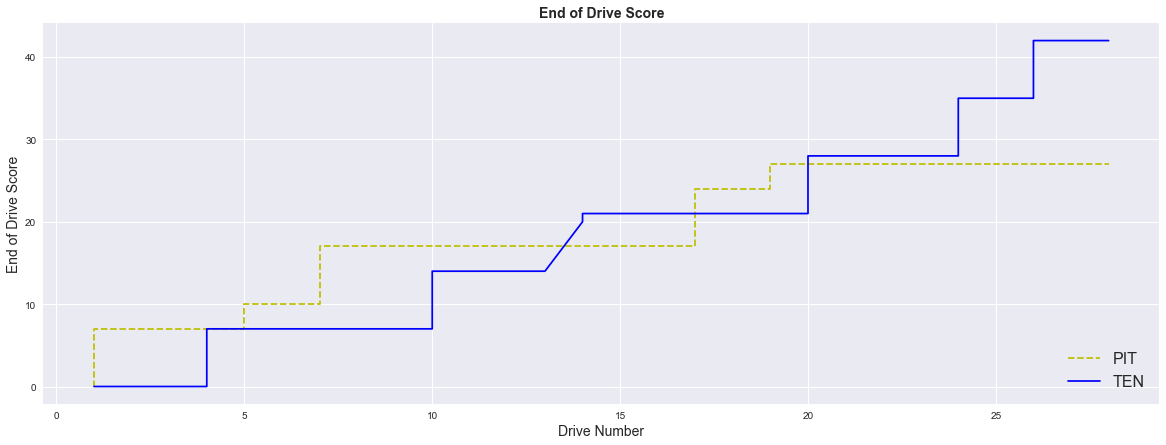

In [230]:
# Reset Fig
plt.close('all')
plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(20,7))
# plt.gca().invert_xaxis()

line1 = ax1.plot(kc_ne_game['drive'],kc_ne_game['total_home_score'],'y--',label='PIT')
line2 = ax1.plot(kc_ne_game['drive'],kc_ne_game['total_away_score'],'b-',label='TEN')

ax1.set_xlabel('Drive Number',fontsize=14)
ax1.set_ylabel('End of Drive Score',fontsize=14)
ax1.set_title("End of Drive Score",fontsize=14,fontweight='bold')

ax1.legend(loc=4,fontsize=16)

plt.show()

<h2>Adding Weather Effects</h2>

In [246]:
combined_df = pd.read_csv('nfl_small_end_of_sum.csv').drop(columns=['Unnamed: 0'])
combined_df.head()

,game_id,Team,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against,win,pass_run_ratio,yard_diff,to_diff,fg_rate,fg_rate_against,pass_yds_per_at,run_yds_per_at,pass_yds_per_at_against,run_yds_per_at_against,team_encode,team_against_encode
0,2017090700,NE,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0,0.0,1.15,-113.0,1.0,1.0,0.5,6.333333,3.676471,9.263158,7.958333,5,5
1,2017091000,BUF,NYJ,21,12,400.0,199.0,39.0,14.0,29.0,41.0,2.0,3.0,1.0,1.0,2.0,2.0,218.0,176.0,193.0,39.0,1.0,0.74,201.0,-1.0,1.0,1.0,7.517241,4.948718,4.292683,2.785714,3,1
2,2017091001,CHI,ATL,17,23,306.0,372.0,19.0,21.0,44.0,32.0,3.0,0.0,1.0,1.0,3.0,3.0,176.0,308.0,125.0,66.0,0.0,2.32,-66.0,3.0,1.0,1.0,4.000000,6.578947,9.625000,3.142857,3,3
3,2017091002,CIN,BAL,0,20,217.0,255.0,22.0,42.0,36.0,18.0,7.0,1.0,0.0,0.0,2.0,2.0,144.0,111.0,77.0,157.0,0.0,1.64,-38.0,6.0,0.5,1.0,4.000000,3.500000,6.166667,3.738095,2,4
4,2017091003,CLE,PIT,18,20,293.0,287.0,26.0,14.0,37.0,37.0,2.0,3.0,1.0,1.0,0.0,0.0,180.0,255.0,59.0,43.0,0.0,1.42,6.0,-1.0,1.0,0.5,4.864865,2.269231,6.891892,3.071429,1,5


In [240]:
nfl_small2.head()

,play_id,game_id,game_date,time,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,qtr,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,drive,sp,down,goal_to_go,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,pass_length,air_yards,yards_after_catch,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,td_team,total_home_score,total_away_score,posteam_score,defteam_score,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,fumble,complete_pass,Start_Time,diff,Estimated_Time,Estimated Time (EST),Estimated_Hour,Air Pressure (hPa),City,Dewpoint (°C),Field,Humidity (%),Precipitation (mm),Roof,Team Abbreviation,Temperature (°C),Time (EST),Time (GMT),Wind Direction (deg),Wind Speed (km/h),added_time,game_name,end_of_drive,end_of_game,INT,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS,year,week
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
362094,44,2017090700,2017-09-07 00:00:00,15:00,900.0,1800.0,3600.0,Half1,0,1,NE,KC,NE,home,KC,KC,35.0,1,0,NaN,0.0,KC 35,0,73,C.Santos kicks 64 yards from KC 35 to NE 1. D....,kickoff,0.0,0,0.0,0.0,NaN,64.0,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:00.000000000,2017-09-07 20:30:00,2017-09-07 20:30:00,2017-09-07 20:00:00,1011.3,Foxborough,13.8,FieldTurf CORE,65.0,0.0,Open,NE,20.6,2017-09-07 20:00:00,2017-09-08 00:00:00,210.0,22.3,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362095,68,2017090700,2017-09-07 00:00:00,14:55,895.0,1795.0,3595.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,1.0,0.0,NE 27,10,0,(14:55) NE 12-Brady 18th season as Patriots QB...,pass,0.0,deep,27.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:00:15.000000000,2017-09-07 20:30:15,2017-09-07 20:30:15,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362096,94,2017090700,2017-09-07 00:00:00,14:49,889.0,1789.0,3589.0,Half1,0,1,NE,KC,NE,home,KC,NE,73.0,1,0,2.0,0.0,NE 27,10,8,(14:49) T.Brady pass short right to R.Burkhead...,pass,8.0,short,1.0,7.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017-09-07 20:30:00,0 days 00:00:33.000000000,2017-09-07 20:30:33,2017-09-07 20:30:33,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362097,118,2017090700,2017-09-07 00:00:00,14:14,854.0,1754.0,3554.0,Half1,0,1,NE,KC,NE,home,KC,NE,65.0,1,0,3.0,0.0,NE 35,2,73,(14:14) (Shotgun) J.White left guard to NE 43 ...,run,8.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:02:18.000000000,2017-09-07 20:32:18,2017-09-07 20:32:18,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,A,0,0,0,0,H,0,0,0,0,0,0,0,0,0,0,0,2017,1
362098,139,2017090700,2017-09-07 00:00:00,13:52,832.0,1732.0,3532.0,Half1,0,1,NE,KC,NE,home,KC,NE,57.0,1,0,1.0,0.0,NE 43,10,19,"(13:52) (No Huddle, Shotgun) J.White up the mi...",run,3.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-07 20:30:00,0 days 00:03:24.000000000,2017-09-07 20:33:24,2017-09-07 20:33:24,2017-09-07 21:00:00,1012.9,Foxborough,11.6,FieldTurf CORE,67.0,0.0,Open,NE,17.8,2017-09-07 21:00:00,2017-09-08 01:00:00,300.0,20.5,0,KC @ NE 2017-09-07,0,0,0,0,0,0,0,0,0

In [255]:
# combining combined_df and nfl_small2 for weather data using average per game for each value

def agg_func_for_weather(x):
    values = {
        'Temperature (°C)':x['Temperature (°C)'].mean(),
        'Air Pressure (hPa)':x['Air Pressure (hPa)'].mean(),
        'City':x['City'].iloc[0],
        'Field':x['Field'].iloc[0],
        'Dewpoint (°C)':x['Dewpoint (°C)'].mean(),
        'Precipitation (mm)':x['Precipitation (mm)'].mean(),
        'Wind Speed (km/h)':x['Wind Speed (km/h)'].mean()
    }
    return pd.Series(values)

In [256]:
weather_avg_df = nfl_small2.groupby(['game_id']).apply(lambda x: agg_func_for_weather(x))

In [257]:
weather_avg_df.head()

,Temperature (°C),Air Pressure (hPa),City,Field,Dewpoint (°C),Precipitation (mm),Wind Speed (km/h)
game_id,,,,,,,
2017090700,17.814359,1013.282564,Foxborough,FieldTurf CORE,11.439487,0.0,13.215385
2017091000,18.531928,1031.807229,Orchard Park,A-Turf Titan 50,7.090964,0.0,10.100000
2017091001,20.807006,1029.624841,Chicago,Kentucky bluegrass,6.575159,0.0,16.600000
2017091002,21.979141,1027.619632,Cincinnati,UBU Speed Series S5-M Synthetic Turf,8.545399,0.0,20.901227
2017091003,21.227848,1031.128481,Cleveland,Kentucky bluegrass,8.108861,0.0,12.922152


In [262]:
combined_weather_avg_df = combined_df.merge(weather_avg_df, left_on = ['game_id'], right_on = ['game_id'])

In [263]:
combined_weather_avg_df.head()

,game_id,Team,team_against,score,score_against,yards,yards_against,run_plays,run_plays_against,pass_plays,pass_plays_against,to_for,to_against,fg_at,fg_md,fg_at_against,fg_md_against,pass_yards,pass_yards_against,run_yards,run_yards_against,win,pass_run_ratio,yard_diff,to_diff,fg_rate,fg_rate_against,pass_yds_per_at,run_yds_per_at,pass_yds_per_at_against,run_yds_per_at_against,team_encode,team_against_encode,Temperature (°C),Air Pressure (hPa),City,Field,Dewpoint (°C),Precipitation (mm),Wind Speed (km/h)
0,2017090700,NE,KC,27,42,425.0,538.0,34.0,24.0,39.0,38.0,2.0,1.0,2.0,2.0,0.0,0.0,247.0,352.0,125.0,191.0,0.0,1.15,-113.0,1.0,1.0,0.5,6.333333,3.676471,9.263158,7.958333,5,5,17.814359,1013.282564,Foxborough,FieldTurf CORE,11.439487,0.0,13.215385
1,2017090700,KC,NE,42,27,538.0,425.0,24.0,34.0,38.0,39.0,1.0,2.0,0.0,0.0,2.0,2.0,352.0,247.0,191.0,125.0,1.0,1.58,113.0,-1.0,0.5,1.0,9.263158,7.958333,6.333333,3.676471,5,5,17.814359,1013.282564,Foxborough,FieldTurf CORE,11.439487,0.0,13.215385
2,2017091000,BUF,NYJ,21,12,400.0,199.0,39.0,14.0,29.0,41.0,2.0,3.0,1.0,1.0,2.0,2.0,218.0,176.0,193.0,39.0,1.0,0.74,201.0,-1.0,1.0,1.0,7.517241,4.948718,4.292683,2.785714,3,1,18.531928,1031.807229,Orchard Park,A-Turf Titan 50,7.090964,0.0,10.100000
3,2017091000,NYJ,BUF,12,21,199.0,400.0,14.0,39.0,41.0,29.0,3.0,2.0,2.0,2.0,1.0,1.0,176.0,218.0,39.0,193.0,0.0,2.93,-201.0,1.0,1.0,1.0,4.292683,2.785714,7.517241,4.948718,1,3,18.531928,1031.807229,Orchard Park,A-Turf Titan 50,7.090964,0.0,10.100000
4,2017091001,CHI,ATL,17,23,306.0,372.0,19.0,21.0,44.0,32.0,3.0,0.0,1.0,1.0,3.0,3.0,176.0,308.0,125.0,66.0,0.0,2.32,-66.0,3.0,1.0,1.0,4.000000,6.578947,9.625000,3.142857,3,3,20.807006,1029.624841,Chicago,Kentucky bluegrass,6.575159,0.0,16.600000
